In [3]:
import creds
from utils import *
import matplotlib.pyplot as plt

tok = creds.token_ro_all

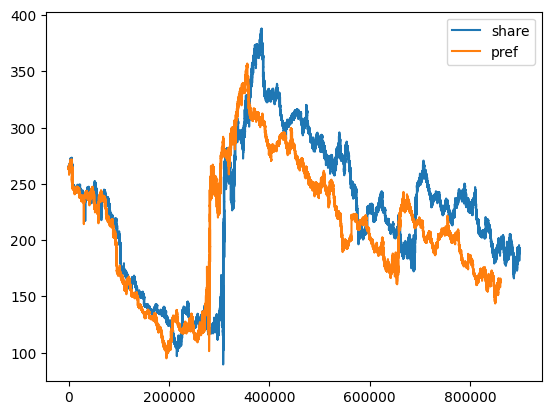

In [4]:

ticker = 'SBER'
share = pd.read_csv(f'../data/shares_data/companies/{ticker}.csv')
pref = pd.read_csv(f'../data/shares_data/companies_pref/{ticker}P.csv')

plt.plot(share['close'], label='share')
plt.plot(pref['close'], label='pref')
plt.legend()

In [5]:
print(share.shape[0])
print(pref.shape[0])

share = pd.merge(share, pref['time'], on='time', how='inner')
pref = pd.merge(pref, share['time'], on='time', how='inner')

899121
860938


859080


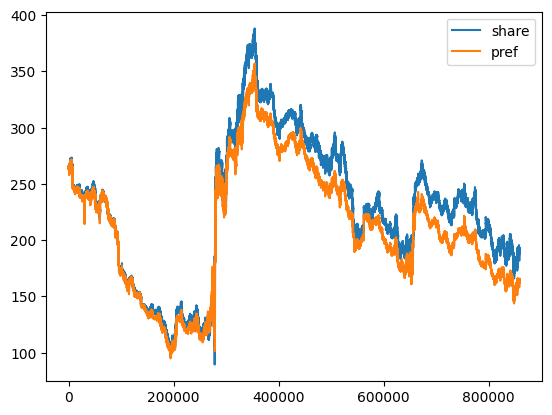

In [6]:
plt.plot(share['close'], label='share')
plt.plot(pref['close'], label='pref')
print(pref.shape[0])
plt.legend()

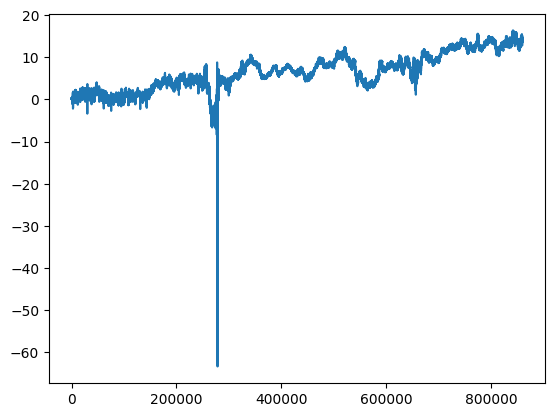

In [7]:
diff = 100*(share['close'] - pref['close']) / share['close']
plt.plot(diff, label='pref')
# plt.ylim(-5, 5)